In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
voc_root = os.path.join(project_root, "data", "VOC2012")

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from data.voc_dataset import VOCDataset
from ssd.anchor import AnchorGenerator
from ssd.encoder import TargetEncoder
from ssd.box_utils import point_form

# Setup Anchor Generator and Encoder

Generate anchors

In [6]:
generator = AnchorGenerator()
anchor_boxes_by_layer = generator.anchor_boxes
prior_boxes = []
for layer in anchor_boxes_by_layer:
    prior_boxes.append(anchor_boxes_by_layer[layer].view(-1, 4))
prior_boxes = torch.cat(prior_boxes, dim=0)
prior_boxes = point_form(prior_boxes, clip=True)
print(prior_boxes.shape)

torch.Size([8096, 4])


Perform encoding and verify that decoding also works.

In [8]:
dataset = VOCDataset('trainval', root=voc_root)
encoder = TargetEncoder(prior_boxes, num_classes=20, iou_threshold=0.50)

gt_boxes has shape torch.Size([1, 4])
gt_labels has shape torch.Size([1])
matched_gts has shape torch.Size([8096, 4])
loc_targets has shape torch.Size([8096, 4])
cls_targets has shape torch.Size([8096, 20])


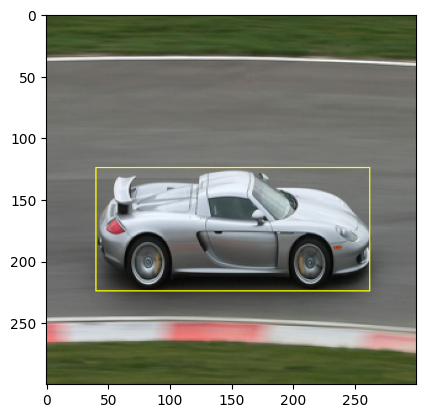

In [10]:
img_tensor, bboxes = dataset[1337]
img_tensor = img_tensor.permute(1, 2, 0).contiguous()

img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
height, width, _ = img.shape

gt_boxes = bboxes[:, :4]
gt_labels = bboxes[:, 4]
print("gt_boxes has shape", gt_boxes.shape)
print("gt_labels has shape", gt_labels.shape)

for i, box in enumerate(gt_boxes):
    xmin, ymin, xmax, ymax = box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 255, 0), thickness=1)
plt.imshow(img)

matched_gts, matched_labels, loc_targets, cls_targets = encoder.encode(gt_boxes, gt_labels)
print("matched_gts has shape", matched_gts.shape)
print("loc_targets has shape", loc_targets.shape)
print("cls_targets has shape", cls_targets.shape)

# Visualize Matched Ground Truth to Each Prior

In [11]:
import colorsys
import numpy as np

def generate_colors(N):
    HSV_tuples = [(x*1.0/N, 1, 1) for x in range(N)]
    RGB_tuples = map(lambda x: tuple(int(val*255) for val in colorsys.hsv_to_rgb(*x)), HSV_tuples)
    return list(RGB_tuples)

Filter away all background priors. We won't visualize them here.

In [12]:
background_filter = cls_targets.argmax(1) != 0
filtered_matched_gts = matched_gts[background_filter]
filtered_loc_targets = loc_targets[background_filter]
filtered_cls_targets = cls_targets[background_filter]
filtered_prior_boxes = prior_boxes[background_filter]
f"Found {filtered_prior_boxes.size(0)} non-background prior boxes"

'Found 17 non-background prior boxes'

Ground truth boxes are shown in yellow. Prior boxes are shown in red.

Text(0.5, 1.0, 'Prior Boxes')

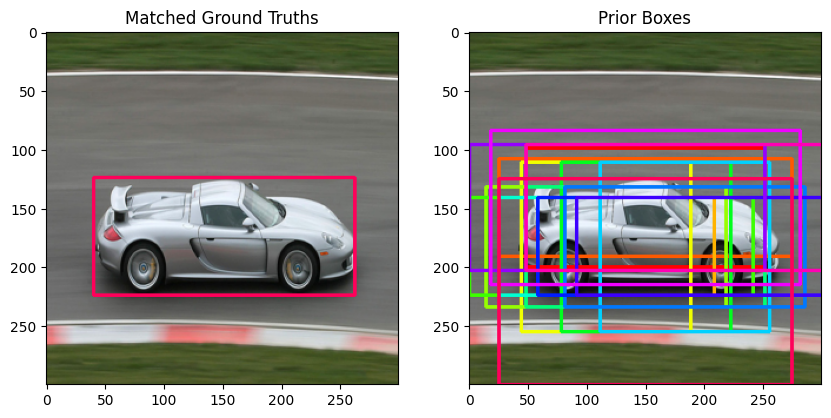

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

left_img = img_tensor.numpy() * 255
left_img = left_img.astype(np.uint8)
height, width, _ = left_img.shape

colors = generate_colors(filtered_prior_boxes.size(0))

# Every prior has a matching ground truth box
for i, matched_gt_box in enumerate(filtered_matched_gts):
    xmin, ymin, xmax, ymax = matched_gt_box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(left_img, (umin, vmin), (umax, vmax), color=colors[i], thickness=2)
axs[0].imshow(left_img)
axs[0].set_title("Matched Ground Truths")

right_img = img_tensor.numpy() * 255
right_img = right_img.astype(np.uint8)
height, width, _ = right_img.shape

# Compare it to the original prior box.
for i, prior_box in enumerate(filtered_prior_boxes):
    xmin, ymin, xmax, ymax = prior_box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(right_img, (umin, vmin), (umax, vmax), color=colors[i], thickness=2)
axs[1].imshow(right_img)
axs[1].set_title("Prior Boxes")

# Check Decoding Logic

The localization targets should decode to boxes that **may not** match perfectly to ground truths because of the added variances.

In [14]:
loc_targets.shape

torch.Size([8096, 4])

In [16]:
decoded_boxes = encoder.decode_localization(loc_targets)
filtered_decoded_boxes = decoded_boxes[background_filter]
filtered_decoded_boxes.shape

torch.Size([17, 4])

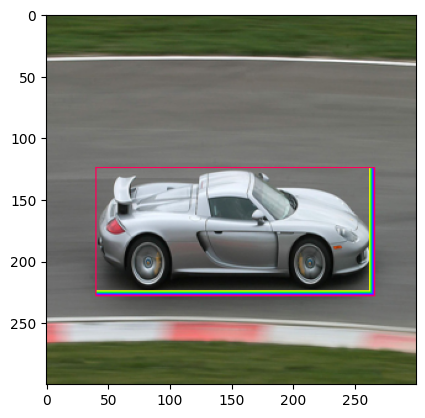

In [17]:
img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
height, width, _ = img.shape

# Every prior has a matching ground truth box
N = filtered_decoded_boxes.size(0)
for i, decoded_box in enumerate(filtered_decoded_boxes):
    xmin, ymin, xmax, ymax = decoded_box
    umin, vmin = int(xmin * width), int(ymin * height)
    # Since each box is stacking on top of each other, I will make it a bit more visible by shifting
    # the bottom-right corner a bit.
    umax, vmax = int(xmax * width) + int(5 * i / N), int(ymax * height)  + int(5 * i / N)
    cv2.rectangle(img, (umin, vmin), (umax, vmax), color=colors[i], thickness=1)

plt.imshow(img)